In [1]:
%load_ext autoreload
%autoreload 2

In [26]:
from pydrake.all import (
    ModelVisualizer,
    StartMeshcat,
    Simulator,
)
import pydot

from IPython.display import SVG, display
from manipulation import running_as_notebook
from manipulation.station import MakeHardwareStation, load_scenario
import matplotlib.pyplot as plt
import numpy as np

import sponana.utils

In [3]:
# Start the visualizer.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7001


In [5]:
inspect_spot_model = False

if inspect_spot_model:
    # Inspecting the Spot Model
    visualizer = ModelVisualizer(meshcat=meshcat)
    sponana.utils.configure_parser(visualizer.parser())
    visualizer.AddModels(url="package://manipulation/spot/spot_with_arm.urdf")
    visualizer.Run(loop_once=not running_as_notebook)
    meshcat.DeleteAddedControls()

In [6]:
def create_scene(scenario_data: str):
    # Clean up the Meshcat instance.
    meshcat.Delete()
    meshcat.DeleteAddedControls()

    scenario = load_scenario(data=scenario_data)
    station = MakeHardwareStation(
        scenario, meshcat, package_xmls=sponana.utils.PACKAGE_XMLS
    )

    return station

In [15]:
def initialize_simulation(diagram):
    simulator = Simulator(diagram)
    simulator.Initialize()
    simulator.set_target_realtime_rate(1.0)
    return simulator


def run_simulation(scenario_data):
    station = create_scene(scenario_data)
    simulator = initialize_simulation(station)
    meshcat.StartRecording()
    finish_time = 2.0
    simulator.AdvanceTo(finish_time)
    meshcat.PublishRecording()
    return station, simulator

In [46]:
scenario_data = """
cameras:
    main_camera:
        name: camera0
        depth: True
        X_PB:
            base_frame: world
            translation: [0, 0, 1.0]
            rotation: !Rpy { deg: [180, 0, 90]}
directives:
- add_model:
    name: spot
    file: package://manipulation/spot/spot_with_arm.urdf
    
- add_model:
    name: banana
    file: package://sponana/banana/banana.sdf

- add_model:
    name: floor
    file: package://sponana/platform.sdf

- add_weld:
    parent: world
    child: floor::platform_center
    X_PC:
        translation: [0, 0, -.5]
"""

In [47]:
station, simulator = run_simulation(scenario_data)

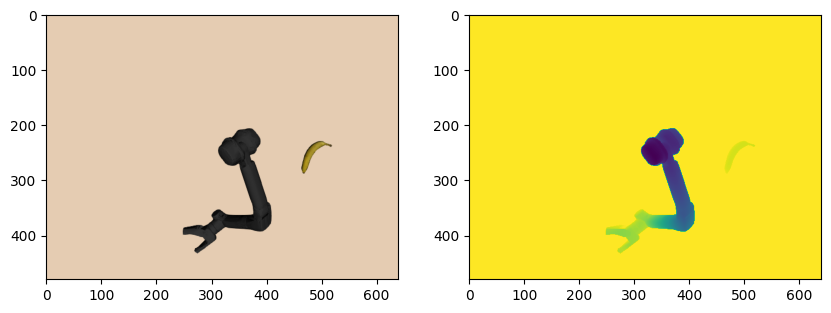

In [48]:
context = simulator.get_mutable_context()
color_image = station.GetOutputPort("camera0.rgb_image").Eval(context)
depth_image = station.GetOutputPort("camera0.depth_image").Eval(context)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(color_image.data)
plt.subplot(1, 2, 2)
plt.imshow(depth_image.data)

In [ ]:
diagram = create_scene(scenario_data)
display(
    SVG(
        pydot.graph_from_dot_data(diagram.GetGraphvizString(max_depth=1))[
            0
        ].create_svg()
    )
)